In [113]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA

In [85]:
data = pd.read_csv("House_Rent_Dataset.csv")


In [106]:
data.head()

,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [89]:
#Removing posted on as it has no relevance to the rent 
del(data['Posted On'])

Finding mutual information between features

In [100]:
X = data.copy()
y = X.pop("Rent")

In [101]:
# Label encoding for categorical features
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int

In [104]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3] 

Area Locality       0.739525
BHK                 0.257137
Floor               0.191804
Tenant Preferred    0.029037
Name: MI Scores, dtype: float64

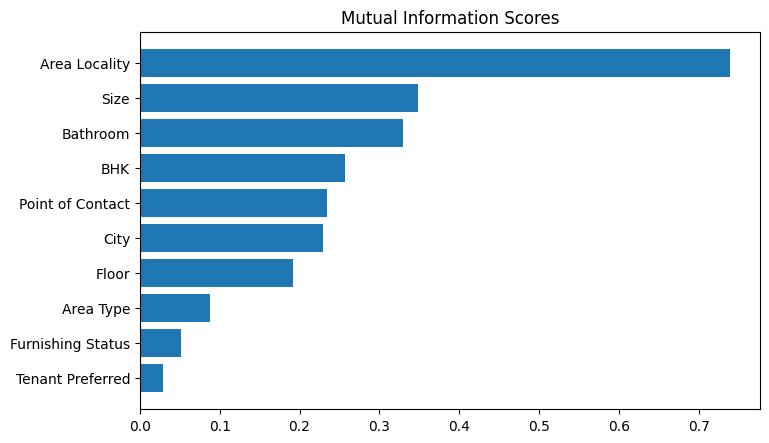

In [105]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

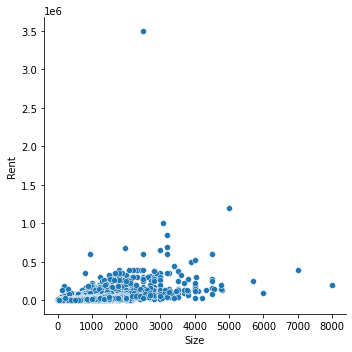

In [114]:
sns.relplot(x="Size", y="Rent", data=data)

In [115]:
#Performing PCA 
pca_featuers = ["BHK", "Bathroom", "Size"]

X = data.copy()
y = X.pop('Rent')
X = X.loc[:, pca_featuers]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [119]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca

,PC1,PC2,PC3
0,0.082372,0.210084,0.066159
1,-0.847838,0.147171,-0.729226
2,-0.669433,0.403896,-0.770628
3,-0.847838,0.147171,-0.729226
4,-0.803237,0.211352,-0.739576
...,...,...,...
4741,-0.006830,0.081722,0.086860
4742,2.244751,0.435142,-0.029662
4743,2.021745,0.114236,0.022091
4744,1.136136,0.115505,-0.783645


In [120]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3
BHK,0.580043,-0.506035,-0.638340
Bathroom,0.586093,-0.284973,0.758476
Size,0.565725,0.814076,-0.131287


In [122]:
del(data['Floor'])
del(data['Point of Contact'])

In [123]:
data["BHK"]=data['BHK'].astype(int)
data["Rent"]=data['Rent'].astype(int)
data["Size"]=data['Size'].astype(int)
data["Bathroom"]=data['Bathroom'].astype(int)

Data Exploration

In [124]:
data.describe()

,BHK,Rent,Size,Bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


In [125]:
data.isnull().any()

BHK                  False
Rent                 False
Size                 False
Area Type            False
Area Locality        False
City                 False
Furnishing Status    False
Tenant Preferred     False
Bathroom             False
dtype: bool

No null values so we can move forward without having to handle missing values

In [135]:
#Splitting data into train and test

y = data.Rent # target
X = data.drop(['Rent'], axis=1) #training data

X=X.join(X_pca)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [136]:
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [137]:
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()


In [138]:
# Apply one-hot encoder to each column with categorical data
object_cols = ['Area Type', 'Furnishing Status', 'Tenant Preferred', 'City', 'Area Locality']
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [139]:
print("MAE:") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE:


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


14562.473131829573


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Trying with XGBoost to improve predictions

In [145]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
model.fit(OH_X_train, y_train, 
             early_stopping_rounds=8, 
             eval_set=[(OH_X_valid, y_valid)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [146]:
preds = model.predict(OH_X_valid)
mean_absolute_error(y_valid, preds)

14778.895506270559